# A quick introduction to Blackjax

BlackJAX is an MCMC sampling library based on [JAX](https://github.com/google/jax). BlackJAX provides well-tested and ready to use sampling algorithms. It is also explicitly designed to be modular: it is easy for advanced users to mix-and-match different metrics, integrators, trajectory integrations, etc.

In this notebook we provide a simple example based on basic Hamiltonian Monte Carlo and the NUTS algorithm to showcase the architecture and interfaces in the library

In [1]:
import functools as ft

import jax
import jax.numpy as jnp
import jax.scipy.stats as stats
import matplotlib.pyplot as plt
import numpy as np

import blackjax.hmc as hmc
import blackjax.nuts as nuts

In [2]:
%load_ext watermark
%watermark -d -m -v -p jax,jaxlib,blackjax

Python implementation: CPython
Python version       : 3.7.0
IPython version      : 7.19.0

jax     : 0.2.13
jaxlib  : 0.1.67
blackjax: 0.1

Compiler    : GCC 9.3.0
OS          : Linux
Release     : 5.11.9-zen1-1-zen
Machine     : x86_64
Processor   : 
CPU cores   : 8
Architecture: 64bit



## The problem

We'll generate observations from a normal distribution of known `loc` and `scale` to see if we can recover the parameters in sampling. Let's take a decent-size dataset with 1,000 points:

In [3]:
loc, scale = 10, 20
observed = np.random.normal(loc, scale, size=1_000)

In [4]:
def potential_fn(loc, scale, observed=observed):
    """Univariate Normal"""
    logpdf = stats.norm.logpdf(observed, loc, scale)
    return -jnp.sum(logpdf)

potential = lambda x: potential_fn(**x)

## HMC

### Set the initial state

The initial state of the HMC algorithm requires not only an initial position, but also the potential energy and gradient of the potential energy at this position. BlackJAX provides a `new_state` function to initialize the state from an initial position.

In [5]:
initial_position = {"loc": 1.0, "scale": 2.0}
initial_state = hmc.new_state(initial_position, potential)
initial_state

HMCState(position={'loc': 1.0, 'scale': 2.0}, potential_energy=DeviceArray(63186.145, dtype=float32), potential_energy_grad={'loc': DeviceArray(-2364.5989, dtype=float32), 'scale': DeviceArray(-61074.047, dtype=float32)})

### Sampler parameters

To initiate the HMC sampler we need to provide a mass matrix, a step size and a fixed number of integration steps. In the near future BlackJAX will provide adaptation algorithms that compute the mass matrix and the step size automatically.

In [6]:
inv_mass_matrix = np.array([.5, .5])
params = hmc.HMCParameters(
    num_integration_steps=60, step_size=1e-3, inv_mass_matrix=inv_mass_matrix
)

### Build the kernel and inference loop

The HMC kernel is easy to obtain:

In [7]:
%%time
hmc_kernel = hmc.kernel(potential, params)
hmc_kernel = jax.jit(hmc_kernel)

CPU times: user 31 ms, sys: 1.6 ms, total: 32.6 ms
Wall time: 30.7 ms


BlackJAX does not provide a default inference loop, but it easy to implement with JAX's `lax.scan`:

In [8]:
def inference_loop(rng_key, kernel, initial_state, num_samples):
    def one_step(state, rng_key):
        state, _ = kernel(rng_key, state)
        return state, state

    keys = jax.random.split(rng_key, num_samples)
    _, states = jax.lax.scan(one_step, initial_state, keys)

    return states

### Inference

In [9]:
%%time
rng_key = jax.random.PRNGKey(0)
states = inference_loop(rng_key, hmc_kernel, initial_state, 10_000)

loc_samples = states.position["loc"].block_until_ready()
scale_samples = states.position["scale"]

CPU times: user 3.8 s, sys: 13.3 ms, total: 3.81 s
Wall time: 3.82 s


Text(0, 0.5, 'scale')

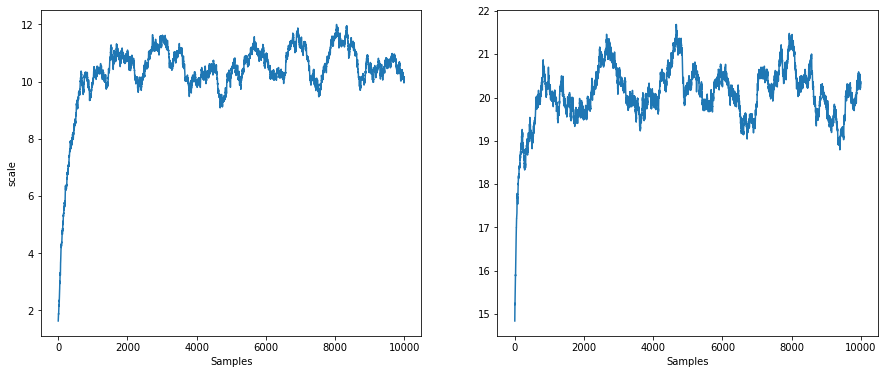

In [10]:
fig, (ax, ax1) = plt.subplots(ncols=2, figsize=(15,6))
ax.plot(loc_samples)
ax.set_xlabel("Samples")
ax.set_ylabel("loc")

ax1.plot(scale_samples)
ax1.set_xlabel("Samples")
ax.set_ylabel("scale")

## NUTS

NUTS is a *dynamic* algorithm: the number of integration steps is determined at runtime. We still need to specify a step size and a mass matrix:

In [11]:
inv_mass_matrix = np.array([.5, .5])
params = nuts.NUTSParameters(
    step_size=1e-3, inv_mass_matrix=inv_mass_matrix
)

In [12]:
initial_position = {"loc": 1.0, "scale": 2.0}
initial_state = nuts.new_state(initial_position, potential)
initial_state

HMCState(position={'loc': 1.0, 'scale': 2.0}, potential_energy=DeviceArray(63186.145, dtype=float32), potential_energy_grad={'loc': DeviceArray(-2364.5989, dtype=float32), 'scale': DeviceArray(-61074.047, dtype=float32)})

In [13]:
%%time
nuts_kernel = jax.jit(nuts.kernel(potential, params))

CPU times: user 3.49 ms, sys: 96 µs, total: 3.59 ms
Wall time: 2.32 ms


In [14]:
%%time
rng_key = jax.random.PRNGKey(0)
states = inference_loop(rng_key, nuts_kernel, initial_state, 4_000)

loc_samples = states.position["loc"].block_until_ready()
scale_samples = states.position["scale"]

CPU times: user 30.7 s, sys: 33.5 ms, total: 30.7 s
Wall time: 30.8 s


Text(0, 0.5, 'scale')

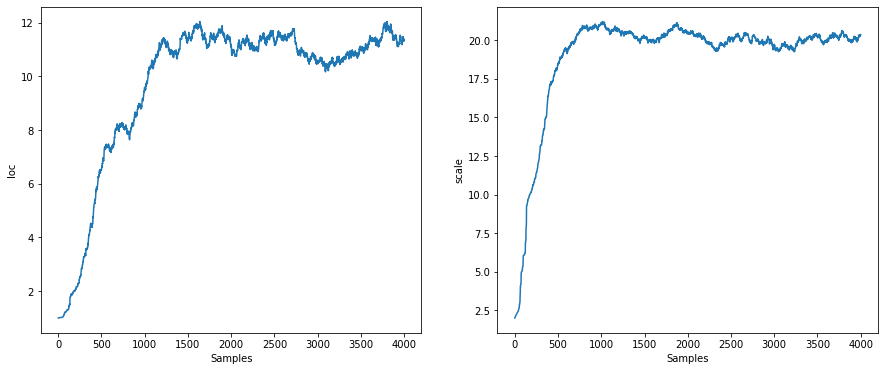

In [15]:
fig, (ax, ax1) = plt.subplots(ncols=2, figsize=(15,6))
ax.plot(loc_samples)
ax.set_xlabel("Samples")
ax.set_ylabel("loc")

ax1.plot(scale_samples)
ax1.set_xlabel("Samples")
ax1.set_ylabel("scale")

## Sample multiple chains

We can easily sample multiple chains using JAX's `vmap` construct. See the [documentation](https://jax.readthedocs.io/en/latest/jax.html?highlight=vmap#jax.vmap) to understand how the mapping works. 

In [16]:
num_chains = 20

initial_positions = {"loc": np.ones(num_chains), "scale": 2. * np.ones(num_chains)}
initial_states = jax.vmap(hmc.new_state, in_axes=(0, None))(initial_positions, potential)

In [17]:
def inference_loop_multiple_chains(rng_key, kernel, initial_state, num_samples, num_chains):
    def one_step(states, rng_key):
        keys = jax.random.split(rng_key, num_chains)
        states, _ = jax.vmap(kernel)(keys, states)
        return states, states

    keys = jax.random.split(rng_key, num_samples)
    _, states = jax.lax.scan(one_step, initial_state, keys)

    return states

In [18]:
%%time
states = inference_loop_multiple_chains(rng_key, hmc_kernel, initial_states, 1_000, num_chains)

CPU times: user 6.84 s, sys: 5.75 ms, total: 6.85 s
Wall time: 6.89 s


In this example the result is a dictionnary and each entry has shape `(num_samples, num_chains)`. Here's how to access the samples of the second chains for `loc`:

In [19]:
states.position['loc'][:,1]

DeviceArray([ 1.7034559,  1.7350358,  1.7682861,  1.884674 ,  1.8374205,
              1.9318616,  2.0081518,  2.0326037,  2.0379682,  2.055426 ,
              2.0276234,  2.1225402,  2.1692631,  2.239247 ,  2.224838 ,
              2.208249 ,  2.2284677,  2.2243347,  2.304786 ,  2.298273 ,
              2.457543 ,  2.4687064,  2.5295513,  2.5938487,  2.574562 ,
              2.6277106,  2.700722 ,  2.733365 ,  2.7376227,  2.7882888,
              2.873467 ,  2.9650714,  2.9577124,  2.9285557,  2.996533 ,
              3.0418117,  3.0806668,  3.110267 ,  3.1600282,  3.2083366,
              3.183337 ,  3.1716375,  3.225754 ,  3.1984713,  3.2232304,
              3.2706752,  3.2582912,  3.2782755,  3.2236204,  3.2637453,
              3.2055583,  3.2771988,  3.3663554,  3.3763258,  3.3360896,
              3.4279194,  3.4385684,  3.4597723,  3.463362 ,  3.4751287,
              3.520903 ,  3.5922031,  3.5814161,  3.5839138,  3.6521554,
              3.6740642,  3.7319496,  3.7328596,  3